## 2.6 Q学習で迷路を攻略

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


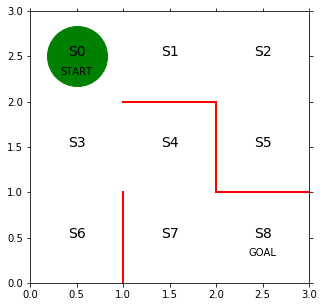

In [5]:
#迷宫的初始位置

#声明图的大小以及图的变量名
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

#画出红色的墙壁
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

#画出表示状态的文字S0-S8
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

#设定画图的范围
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

#当前位置S0用绿色圆圈画出
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)


In [6]:
#设定参数θ的初始值theta_0，用于确定初始方案

#行为状态0-7，列为↑，→，↓，←表示的移动方向
theta_0 = np.array([[np.nan, 1, 1, np.nan],  # s0
                    [np.nan, 1, np.nan, 1],  # s1
                    [np.nan, np.nan, 1, 1],  # s2
                    [1, 1, 1, np.nan],  # s3
                    [np.nan, np.nan, 1, 1],  # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],  # s7、※s8是目标，无策略
                    ])

In [7]:
# 将策略参数theta_0转换为随机策略


def simple_convert_into_pi_from_theta(theta):
    '''简单计算比率'''

    [m, n] = theta.shape  # 读取theta矩阵的大小
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])  # 计算比率

    pi = np.nan_to_num(pi)  # 将nan转换为0

    return pi

# 求取随机行动策略
pi_0 = simple_convert_into_pi_from_theta(theta_0)

In [8]:
# 设置初始的动作价值函数
'''以上的代码和前面完全相同。由于不知道正确的动作价值，因此对初始状态赋予随机值'''
[a, b] = theta_0.shape  # 行と列の数をa, bに格納
Q = np.random.rand(a, b) * theta_0*0.1
# 将theta_0乘到各元素上，使得Q的墙壁方向的值为nan


In [9]:
# 实现ε-贪婪法


def get_action(s, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]

    # 确定行动
    if np.random.rand() < epsilon:
        # 以ε概率随机行动
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        # 采用Q的最大值对应的动作
        next_direction = direction[np.nanargmax(Q[s, :])]

    # 为动作加上索引
    if next_direction == "up":
        action = 0
    elif next_direction == "right":
        action = 1
    elif next_direction == "down":
        action = 2
    elif next_direction == "left":
        action = 3

    return action


def get_s_next(s, a, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    next_direction = direction[a]  # 动作a对应的方向

    # 由动作确定下一个状态
    if next_direction == "up":
        s_next = s - 3  # 向上移动时，状态数减3
    elif next_direction == "right":
        s_next = s + 1  # 向右移动时，状态数加1
    elif next_direction == "down":
        s_next = s + 3  # 向下移动时，状态数加3
    elif next_direction == "left":
        s_next = s - 1  # 向左移动时，状态数减1

    return s_next


#### Q学习的Q更新公式是：$Q(s_t,a_t)=Q(s_t,a_t)+\eta*(R_{t+1}+\gamma*\max_{a}Q(s_{t+1},a)-Q(s_t,a_t))$

In [10]:
# 基于Q学习的动作价值函数Q的更新


def Q_learning(s, a, r, s_next, Q, eta, gamma):

    if s_next == 8:  # 到达目标时
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])

    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * np.nanmax(Q[s_next,: ]) - Q[s, a])

    return Q

In [13]:
# 定义基于Q学习求解迷宫问题的函数，输出状态，动作的历史记录以及更新后的Q


def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s = 0  # 开始地点
    a = a_next = get_action(s, Q, epsilon, pi)  # 初始动作
    s_a_history = [[0, np.nan]]  # 记录智能体的移动序列

    while (1):  # 循环直到到达目标
        a = a_next  # 跟新动作

        s_a_history[-1][1] = a
        # 将动作放在现在的状态下（最终的index=-1）

        s_next = get_s_next(s, a, Q, epsilon, pi)
        # 有效的下一个状态

        s_a_history.append([s_next, np.nan])
        # 代入下一个状态，动作未知时为nan

        # 给予奖励，求得下一个动作
        if s_next == 8:
            r = 1  # 达到目标，给予奖励
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
            # 求得下一个动作a_next

        # 更新价值函数
        Q = Q_learning(s, a, r, s_next, Q, eta, gamma)

        # 终止判断
        if s_next == 8:  # 到达目的地则结束
            break
        else:
            s = s_next

    return [s_a_history, Q]

In [16]:
# 通过Q学习求解迷宫问题

eta = 0.1  # 学习率
gamma = 0.9  # 时间折扣率
epsilon = 0.5  # ε-greedy法的初始值
v = np.nanmax(Q, axis=1)  # 根据状态求价值的最大
is_continue = True
episode = 1

V=[] #存放每回合的状态价值
V.append(np.nanmax(Q,axis=1)) #求各个状态下动作价值的最大值

while is_continue:  # 循环直到is_continue为False
    print("当前回合:" + str(episode))

    # ε-greedy的値逐渐减少
    epsilon = epsilon / 2

    # 通过Q学习求解迷宫问题，求取移动历史和更新后的Q值
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)

    # 状态价值的变化
    new_v = np.nanmax(Q, axis=1)  # 各状态求得最大价值
    print(np.sum(np.abs(new_v - v)))  # 输出状态价值的变化
    v = new_v
    V.append(v) #添加该回合终止时的状态价值函数

    print("求解迷宫问题所需步数" + str(len(s_a_history) - 1) )

    # 重复100回合
    episode = episode + 1
    if episode > 100:
        break


当前回合:1
0.0006977890772398299
求解迷宫问题所需步数6
当前回合:2
0.06206174760467234
求解迷宫问题所需步数6
当前回合:3
0.0004944817814270808
求解迷宫问题所需步数4
当前回合:4
0.0004560754525554378
求解迷宫问题所需步数4
当前回合:5
0.00042059875955369197
求解迷宫问题所需步数4
当前回合:6
0.00038783207619319526
求解迷宫问题所需步数4
当前回合:7
0.0003575720257220638
求解迷宫问题所需步数4
当前回合:8
0.0003296302807371809
求解迷宫问题所需步数4
当前回合:9
0.0003038324536813741
求解迷宫问题所需步数4
当前回合:10
0.0002800170706845906
求解迷宫问题所需步数4
当前回合:11
0.0002580346221271457
求解迷宫问题所需步数4
当前回合:12
0.000237746683873441
求解迷宫问题所需步数4
当前回合:13
0.00021902510366267336
求解迷宫问题所需步数4
当前回合:14
0.00020175124760690721
求解迷宫问题所需步数4
当前回合:15
0.00018581530218197972
求解迷宫问题所需步数4
当前回合:16
0.00017111562747651465
求解迷宫问题所需步数4
当前回合:17
0.00015755815781937077
求解迷宫问题所需步数4
当前回合:18
0.00014505584622181988
求解迷宫问题所需步数4
当前回合:19
0.00013352814935641
求解迷宫问题所需步数4
当前回合:20
0.00012290055005914624
求解迷宫问题所需步数4
当前回合:21
0.00011310411457787772
求解迷宫问题所需步数4
当前回合:22
0.00010407508201026872
求解迷宫问题所需步数4
当前回合:23
9.575448356813343e-05
求解迷宫问题所需步数4
当前回合:24
8.808778949076501e-05
求解迷宫问题所

In [ ]:
# 通过Sarsa求解迷宫问题

eta = 0.1  # 学习率
gamma = 0.9  # 时间折扣率
epsilon = 0.5  # ε-greedy法的初始值
v = np.nanmax(Q, axis=1)  # 根据状态求价值的最大
is_continue = True
episode = 1

while is_continue:  # 循环直到is_continue为False
    print("当前回合:" + str(episode))

    # ε-greedy的値逐渐减少
    epsilon = epsilon / 2

    # 通过Sarsa求解迷宫问题，求取移动历史和更新后的Q值
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)

    # 状态价值的变化
    new_v = np.nanmax(Q, axis=1)  # 各状态求得最大价值
    print(np.sum(np.abs(new_v - v)))  # 输出状态价值的变化
    v = new_v

    print("求解迷宫问题所需步数" + str(len(s_a_history) - 1) )

    # 重复100回合
    episode = episode + 1
    if episode > 100:
        break